In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.decomposition import PCA
from scvi.model import TOTALVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Global seed set to 0


In [2]:
dataset = "papalexi_2021"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
    )
)

target_adata = adata[adata.obs["crispr"] != "NT"].copy()
background_adata = adata[adata.obs["crispr"] == "NT"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

TOTALVI.setup_anndata(target_adata, layer="count", protein_expression_obsm_key="protein_expression")
TOTALVI.setup_anndata(target_trans_adata, protein_expression_obsm_key="protein_expression")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 18343 cells, 2000 vars, 1 batches,
         1 labels, and 4 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same

In [4]:
seeds = [123]
latent_size = 10

results_path = "/projects/leelab/contrastiveVI/results-different-normalization/"
#results_path = constants.DEFAULT_RESULTS_PATH

total_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            results_path,
            f"{dataset}/total_contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

total_vi_latent_representations = [
    np.load(
        os.path.join(
            results_path,
            f"{dataset}/totalVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

mixscape_10_representations = [
    np.load(
        os.path.join(
            results_path,
            f"{dataset}/mixscape/latent_{10}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

mixscape_40_representations = [
    np.load(
        os.path.join(
            results_path,
            f"{dataset}/mixscape/latent_{40}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


In [5]:
total_contrastiveVI_models = [
    torch.load(
        os.path.join(constants.DEFAULT_RESULTS_PATH, f"{dataset}/total_contrastiveVI/latent_{latent_size}/{seed}/model.ckpt"),
    )
    for seed in tqdm(seeds)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.30s/it]


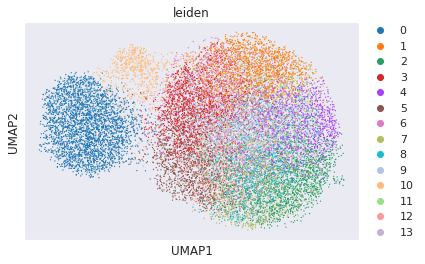

In [6]:
from anndata import AnnData
latent_adata = AnnData(X=total_contrastive_vi_latent_representations[0], obs=target_adata.obs)
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.tl.leiden(latent_adata)
sc.pl.umap(latent_adata, color='leiden')

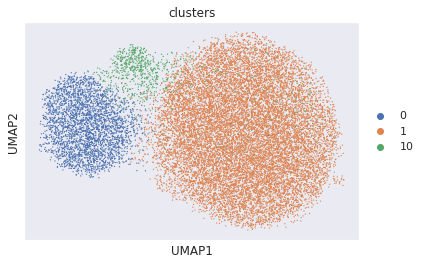

In [7]:
# Janky way of labeling the three noticeable clusters
latent_adata.obs['clusters'] = [x if x in ["0", "10"] else "1" for x in latent_adata.obs['leiden']]
sc.pl.umap(latent_adata, color='clusters')

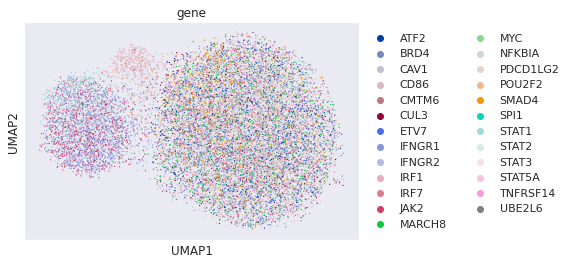

In [8]:
# Attempting to figure out what the clusters mean
sc.pl.umap(latent_adata, color='gene')

In [9]:
latent_adata.obs['clusters_readable'] = [
    "IRF1" if x == "10" else "IFN-g" if x == "0" else "No Effect" for x in latent_adata.obs['clusters']
]

In [10]:
rna, protein = total_contrastiveVI_models[0].get_normalized_expression(
    target_adata,
    n_samples=25,
    return_mean=True,
)["salient"]


In [11]:
rna_bg, protein_bg = total_contrastiveVI_models[0].get_normalized_expression(
    background_adata,
    n_samples=25,
    return_mean=True,
)["background"]


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels', 'protein_expression']              
INFO     Successfully registered anndata object containing 2386 cells, 2000 vars, 1 batches, 
         1 labels, and 4 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [12]:
background_protein_adata = sc.AnnData(X=protein_bg, obs=background_adata.obs)

In [13]:
background_protein_adata.obs["leiden"] = "-1"
background_protein_adata.obs["clusters"] = "-1"
background_protein_adata.obs["clusters_readable"] = "Control"

In [14]:
target_protein_adata = sc.AnnData(X=protein, obs=latent_adata.obs)

In [15]:
full_protein_adata = sc.AnnData.concatenate(target_protein_adata, background_protein_adata)

/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


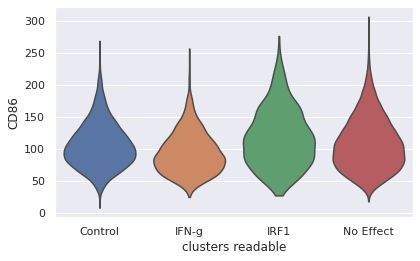

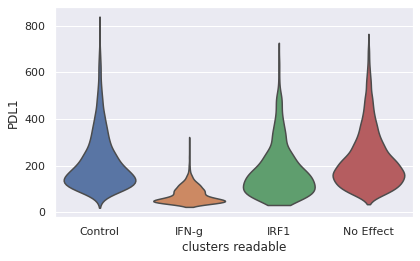

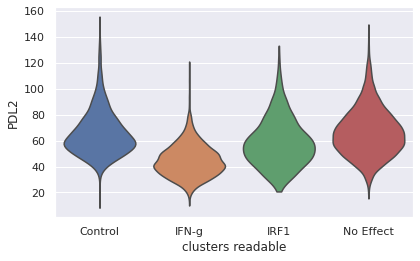

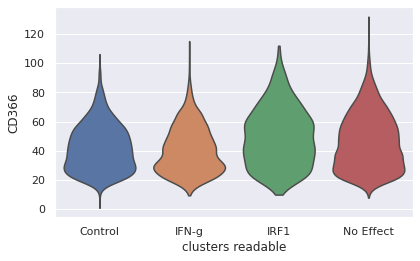

In [16]:
for protein_name in full_protein_adata.var_names:
    sc.pl.violin(full_protein_adata, keys=protein_name, groupby="clusters_readable", stripplot=False)

In [17]:
adata.obs['clusters_readable'] = "Placeholder"
target_indices = np.where(adata.obs["crispr"] != "NT")[0]
background_indices = np.where(adata.obs["crispr"] == "NT")[0]

adata.obs['clusters_readable'][target_indices] = target_protein_adata.obs['clusters_readable']
adata.obs['clusters_readable'][background_indices] = background_protein_adata.obs['clusters_readable']

/tmp/ipykernel_29148/2741850314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['clusters_readable'][target_indices] = target_protein_adata.obs['clusters_readable']
/tmp/ipykernel_29148/2741850314.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['clusters_readable'][background_indices] = background_protein_adata.obs['clusters_readable']


In [18]:
group_indices = np.where(adata.obs["clusters_readable"] == "IFN-g")[0]

In [19]:
tmp_adata = adata.copy()
cluster_label = 'clusters'

model = total_contrastiveVI_models[0]

# IFN-g cluster vs background
de_result_0_vs_background = model.differential_expression(
    adata=tmp_adata,
    groupby=cluster_label,
    idx1=background_indices,
    idx2=group_indices,
    mode="change",
    delta=0.20,
    batch_size=128,
    all_stats=True,
    batch_correction=False,
    batchid1=None,
    batchid2=None,
    fdr_target=0.05,
    silent=False,
    target_idx=group_indices,
    protein_prior_count=0.5
)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels', 'protein_expression']              
INFO     Successfully registered anndata object containing 20729 cells, 2000 vars, 1 batches,
         1 labels, and 4 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:32<00:00, 212.27s/it]


In [20]:
de_result_0_vs_background.loc["PDL1"]

proba_de                     0.9426
proba_not_de                 0.0574
bayes_factor               2.798598
scale1                    214.59903
scale2                    76.097916
pseudocounts                    0.0
delta                           0.2
lfc_mean                   1.447302
lfc_median                 1.429965
lfc_std                    0.955215
lfc_min                   -2.336935
lfc_max                    4.296151
raw_mean1                218.469824
raw_mean2                 70.669067
non_zeros_proportion1           1.0
non_zeros_proportion2           1.0
raw_normalized_mean1            NaN
raw_normalized_mean2            NaN
is_de_fdr_0.05                 True
Name: PDL1, dtype: object

In [21]:
background_indices = np.where(adata.obs["crispr"] == "NT")[0]
group_indices = np.where(adata.obs["clusters_readable"] == "No Effect")[0] #Orange cluster

In [22]:
tmp_adata = adata.copy()
cluster_label = 'clusters'

model = total_contrastiveVI_models[0]

# "No Effect" cluster vs background
de_result_1_vs_background = model.differential_expression(
    adata=tmp_adata,
    groupby=cluster_label,
    idx1=background_indices,
    idx2=group_indices,
    mode="change",
    delta=0.20,
    batch_size=128,
    all_stats=True,
    batch_correction=False,
    batchid1=None,
    batchid2=None,
    fdr_target=0.05,
    silent=False,
    target_idx=group_indices
)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels', 'protein_expression']              
INFO     Successfully registered anndata object containing 20729 cells, 2000 vars, 1 batches,
         1 labels, and 4 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:25<00:00, 205.63s/it]


In [23]:
de_result_1_vs_background.loc["PDL1"]

proba_de                     0.8496
proba_not_de                 0.1504
bayes_factor               1.731467
scale1                   217.189728
scale2                    225.23378
pseudocounts                    0.0
delta                           0.2
lfc_mean                  -0.052741
lfc_median                -0.060921
lfc_std                    1.052298
lfc_min                   -4.366221
lfc_max                    3.645587
raw_mean1                218.469824
raw_mean2                217.601922
non_zeros_proportion1           1.0
non_zeros_proportion2      0.999931
raw_normalized_mean1            NaN
raw_normalized_mean2            NaN
is_de_fdr_0.05                False
Name: PDL1, dtype: object